# Data Analytics Challenge with Apache Spark

The objective of this challenge is to analyze using Apache Spark a data set containing the results of an experiment involving three algorithms.

The data set contains the results of three different algorithms (Model, CBC and NEWCBC) applied to instances characterized by 4 features (F1-F4). Each experiment was repeated 10 times (Rep, but notice that in 2 cases we only made one repetition) generating randomly the instances. It is important to note that the F3 feature is actually a range of values and at each repetition a new value is randomly generated within the range. For this reason, instances belonging to the same group can have distinct F3 values.

In addition:
1. *MODEL_OF* represents the value of the objective function obtained by the algorithm M
2. *MODEL_TIME* represents the time spent by the algorithm M
3. *CBC_OF* represents the value of the objective function obtained by the CBC algorithm
4. *CBC_TIME* represents the time spent by the CBC algorithm
5. *CBC_FC* represents the number of FC-type actions executed by the CBC algorithm
6. *CBC_PC* represents the number of PC-type actions executed by the CBC algorithm
7. *NEWCBC_OF* represents the value of the objective function obtained by the NEWCBC algorithm
8. *NEWCBC_TIME* represents the time spent by the NEWCBC algorithm
9. *NEWCBC_FC* represents the number of FC-type actions executed by the NEWCBC algorithm

In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

spark = SparkSession.builder \
        .master("local[*]") \
        .getOrCreate()

First of all, let's read the excel files into a pandas dataframe (because Spark doesn't have native support for xlsx files).

In [29]:
df = pd.read_excel('data/risultati_A_zaini_piccoli_9-11.xlsx')
df = df.append(pd.read_excel('data/risultati_B_piccole_45-55_1big_knapsack.xlsx'))
df = df.append(pd.read_excel('data/risultati_C_piccole_45-55.xlsx'))
df = df.append(pd.read_excel('data/risultati_D_con_piu_zaini.xlsx'))
df = df.append(pd.read_excel('data/risultati_E_con_piu_items.xlsx'))
df = df.append(pd.read_excel('data/risultati_F_zaini_piccoli_27-33.xlsx'))

We can now move the data into Spark by creating a Spark Dataframe. Then we can check the size of the dataframe and the schema that had been inferred by Spark itself.

In [30]:
dataset = spark.createDataFrame(df)

In [31]:
print(dataset.count())
dataset.printSchema()
dataset.show(5)

400
root
 |-- F1: long (nullable = true)
 |-- F2: long (nullable = true)
 |-- F3: long (nullable = true)
 |-- F4: string (nullable = true)
 |-- Rep: long (nullable = true)
 |-- MODEL_OF: long (nullable = true)
 |-- MODEL_OFUB: long (nullable = true)
 |-- MODEL_TIME: double (nullable = true)
 |-- CBC_OF: long (nullable = true)
 |-- CBC_TIME: double (nullable = true)
 |-- CBC_FC: long (nullable = true)
 |-- CBC_PC: long (nullable = true)
 |-- NEWCBC_OF: long (nullable = true)
 |-- NEWCBC_TIME: double (nullable = true)
 |-- NEWCBC_FC: long (nullable = true)

+---+---+---+---+---+--------+----------+----------+------+--------+------+------+---------+-----------+---------+
| F1| F2| F3| F4|Rep|MODEL_OF|MODEL_OFUB|MODEL_TIME|CBC_OF|CBC_TIME|CBC_FC|CBC_PC|NEWCBC_OF|NEWCBC_TIME|NEWCBC_FC|
+---+---+---+---+---+--------+----------+----------+------+--------+------+------+---------+-----------+---------+
|  3|400|  9|  A|  1|     197|       197|      0.29|   197|    0.02|     0|     1|      197| 

## Descriptive statistics

For the sake of readability, we will use the function *toPandas()* instead of *show()* when showing tables because it works better when using Jupyter notebooks.

In [32]:
dataset.describe("F1", "F2", "F3", "MODEL_TIME", "MODEL_OF", "MODEL_OFUB", "CBC_TIME", "CBC_OF", "CBC_FC", "CBC_PC", "NEWCBC_TIME", "NEWCBC_OF", "NEWCBC_FC").toPandas()

,summary,F1,F2,F3,MODEL_TIME,MODEL_OF,MODEL_OFUB,CBC_TIME,CBC_OF,CBC_FC,CBC_PC,NEWCBC_TIME,NEWCBC_OF,NEWCBC_FC
0,count,400,400,400,400,400,400,400,400,400,400,400,400,400
1,mean,6.775,525.0,9.5675,293.390935,281.9075,284.1775,254.80618250000003,281.8625,0.0825,9.7475,0.1979125,281.81,0.0
2,stddev,3.8680459470670145,120.04593941038696,2.2187272537575264,880.5823451249037,102.20495867468581,105.388651730316,775.7127981301821,102.18639214984304,0.45410271215106984,29.400164419944993,0.23503598581988636,102.08676785179391,0.0
3,min,3,400,6,0.08,82,82,0.01,82,0,0,0.011,82,0
4,max,20,1000,19,3600.0,658,658,3600.0,658,5,255,1.562,658,0


Let's see the distribution of the features variables by plotting them in a box plot.

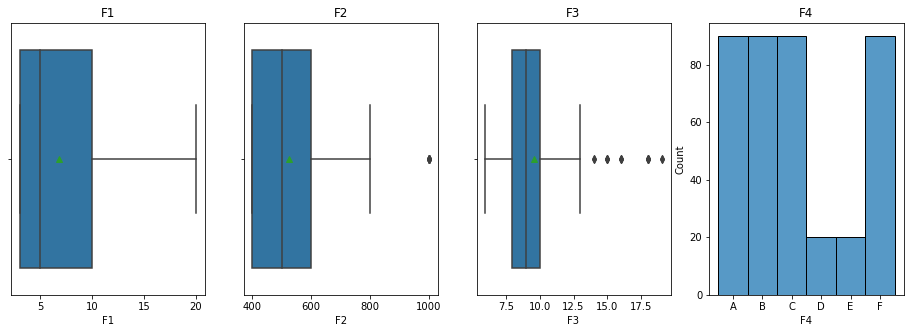

In [33]:
fig, axes = plt.subplots(ncols=4, figsize=(16, 5))
fig.set_facecolor('white')

sns.boxplot(df['F1'], showmeans=True, ax=plt.subplot(1, 4, 1))
plt.title("F1")
sns.boxplot(df['F2'], showmeans=True, ax=plt.subplot(1, 4, 2))
plt.title("F2")
sns.boxplot(df['F3'], showmeans=True, ax=plt.subplot(1, 4, 3))
plt.title("F3")
sns.histplot(df['F4'], ax=plt.subplot(1, 4, 4))
plt.title("F4")

plt.show()

We can also plot the distribution of TIME and OF for each algorithm on a histogram.

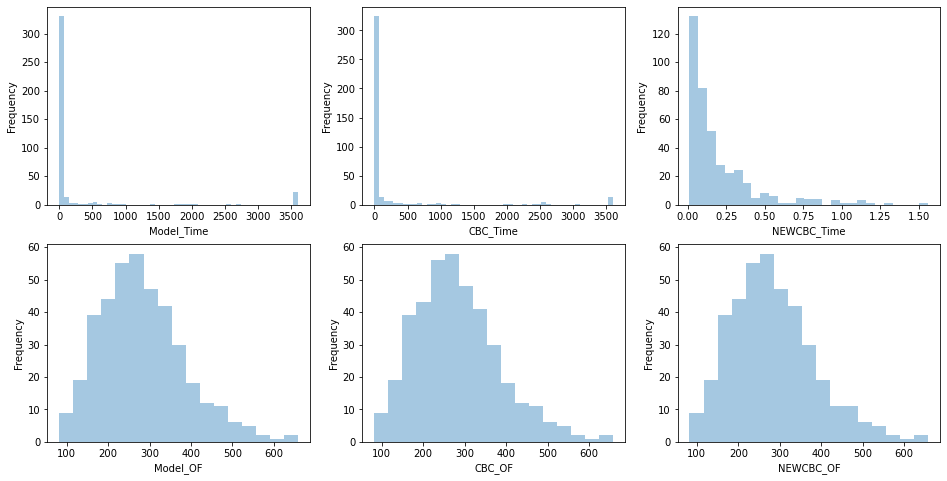

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

sns.distplot(df['MODEL_TIME'], kde=False, ax=plt.subplot(2, 3, 1)) 
plt.xlabel('Model_Time')
plt.ylabel('Frequency')

sns.distplot(df['MODEL_OF'], kde=False, ax=plt.subplot(2, 3, 4)) 
plt.xlabel('Model_OF')
plt.ylabel('Frequency')

sns.distplot(df['CBC_TIME'], kde=False, ax=plt.subplot(2, 3, 2)) 
plt.xlabel('CBC_Time')
plt.ylabel('Frequency')

sns.distplot(df['CBC_OF'], kde=False, ax=plt.subplot(2, 3, 5)) 
plt.xlabel('CBC_OF')
plt.ylabel('Frequency')

sns.distplot(df['NEWCBC_TIME'], kde=False, ax=plt.subplot(2, 3, 3)) 
plt.xlabel('NEWCBC_Time')
plt.ylabel('Frequency')

sns.distplot(df['NEWCBC_OF'], kde=False, ax=plt.subplot(2, 3, 6)) 
plt.xlabel('NEWCBC_OF')
plt.ylabel('Frequency')

plt.show()

## Comparing algorithms effectiveness (OF value)

## Comparing algorithms efficiency (TIME value)